In [1]:
import os
# from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torchvision import transforms
from torchvision.models import vgg16
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

D:\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

# 1.数据读取

In [4]:
import json
# 读取json数据
with open(r'd:\data\taobao_sum\train.json', 'r') as f:
    train = json.load(f)
    f.close()
with open(r'd:\data\taobao_sum\test.json', 'r') as f:
    test = json.load(f)
    f.close()
#获取train test
train_x = list(train['train_x'])
train_y = list(train['train_y'])
test_x = list(test['test_x'])
test_y = list(test['test_y'])

# 2.定义模型

In [5]:
class My_model(nn.Module):
    def __init__(self, num_classes=992):
        super(My_model, self).__init__()
        
        # 分类层
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3 * 991, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 将输出改为输出的个数（991）
            nn.Linear(in_features=1024, out_features=num_classes),
        )


    def forward(self, x):
        x = x.cuda()
        x = torch.flatten(x, 1)
        result = self.classifier(x)
        return result

# 3.模型训练

In [6]:
# 调整学习率
loss_save = []
flag = 0
lr =0.08

In [7]:
# 数据打包
class MyDataset(Dataset):
    # Initialize your data, download, etc.
    def __init__(self, data, targets):
        self.len = len(data)
        self.data = data
        self.targets = targets
#         self.transforms = transforms
    def __getitem__(self, index): # 根据索引返回数据和对应的标签
        r_data = self.data[index]  # 相当于TransformDataset的操作
        return r_data, self.targets[index]  # 相当于打包操作
    def __len__(self):
        return self.len

In [8]:
# 训练过程
def train(x,y):
    loss_train=[] # 存储每次loss
    batch_size = 500 # 批量训练大小
    model = My_model() # 创建模型
    
    # 定义优化器
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    
    # 定义损失函数
    loss_func = nn.CrossEntropyLoss() 
    
    # 加载数据
    x = torch.tensor(x) # 将数据转为Tensor类型
    y = torch.tensor(y)

    train_set = MyDataset(x, y)#封装数据x与标签y
    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    print(len(train_loader))
    # 训练2000次
    for i in range(2000):
        loss_temp = 0  # 临时变量用来存储损失值
        for j, (batch_data, batch_label) in enumerate(train_loader):
            #数据放入GPU中
            batch_data, batch_label = batch_data.cuda(), batch_label.cuda()
            # 没有GPU则CPU
#             batch_data, batch_label = batch_data.cpu(), batch_label.cpu()
            # 将模型放入GPU/cpu中            
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model.to(device)
            # 梯度清零
            optimizer.zero_grad()
            # 模型训练
            prediction = model(batch_data)
            # 损失值
            loss = loss_func(prediction, batch_label)
            loss_temp += loss.item()
            # 反向传播
            loss.backward()
            # 梯度更新
            optimizer.step()

        loss_train.append(loss_temp / len(train_loader))
        if i%100 == 0:
            print('[%d] loss: %.4f' % (i + 1, loss_temp / len(train_loader)))

    # 模型保存
    torch.save(model, 'myVGG16_4.pkl')
    return loss_train

In [9]:
loss = train(train_x,train_y)

27
[1] loss: 8.1084
[101] loss: 2.9635
[201] loss: 2.3322
[301] loss: 1.8068
[401] loss: 1.5191
[501] loss: 1.3923
[601] loss: 1.2807
[701] loss: 1.1955
[801] loss: 1.1016
[901] loss: 1.0635
[1001] loss: 1.0320
[1101] loss: 0.9879
[1201] loss: 0.9769
[1301] loss: 0.9457
[1401] loss: 0.9378
[1501] loss: 0.9313
[1601] loss: 0.9202
[1701] loss: 0.8644
[1801] loss: 0.8865
[1901] loss: 0.8842


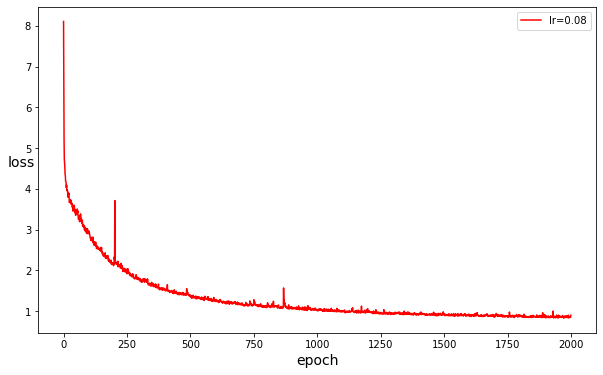

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(2000),loss, 'r',label="lr=0.08")
ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('loss', rotation=0, fontsize=14)
plt.legend(loc="upper right")
plt.show()

# 4.模型测试和评估

In [23]:
# 加载模型
def load_pretrained():
    path = './myVGG16_4.pkl'  # 需要改为自己的路径
    model = torch.load(path)
    return model

In [24]:
#recall@k  模型评估
def Evaluation_recall(pred,y,k):
    correct = 0
    #通过对预测值进行排序取每一维前K个 返回 值 和 对应下标
    pred_vals, pred_indices = pred.topk(k=k, dim=1, largest=True, sorted=True)
    pred_vals[pred_vals>0]=1

    # 遍历 计算出预测正确样本
    for i in range(len(pred_indices)): # 遍历取出每个用户
        # 真实值正结果下标  赛选出大于0
        label_indice = torch.nonzero(y[i])
#         print('label_indice:',label_indice)
        for j in range(k):
            if (pred_indices[i][j] in label_indice) and pred_vals[i][j]==1:
                correct = correct+1
#                 print('i:',i,correct)
                break
            else:
                correct = correct+0
#     print(correct)
    return correct

In [27]:
# 用于存储不同k值下 
recall_k=[]


# 测试过程
def test(x,y,k):
    # 批量数目
    batch_size = 200
    recall_sum = 0
    # 总共n条数据
    n = len(y)
    
    # 加载模型
    model = load_pretrained()

    # 加载数据
    x = torch.tensor(x) # 将数据转为Tensor类型
    y = torch.tensor(y)
    test_set = MyDataset(x, y)#封装数据x与标签y
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    # 开始
    for batch_data, batch_label in test_loader:
        # 放入GPU中
        batch_data, batch_label = batch_data.cuda(), batch_label.cuda()
#         batch_data, batch_label = batch_data.cpu(), batch_label.cpu()
        # 将模型放入GPU/cpu中
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        # 预测
        prediction = model(batch_data)
#         print(prediction)
        # 存放在gpu中数据转到cpu中
        prediction = prediction.cpu()
        batch_label = batch_label.cpu()
        # 对y值进行Softmax dim=1表示第二维
        softmax = nn.Softmax(dim=1)
        prediction = softmax(prediction)
#         batch_label = softmax(batch_label)
        
        # 模型测试
        recall = Evaluation_recall(prediction,batch_label,k)
        recall_sum = recall_sum+recall
    recall_k.append(100 * recall_sum/int(n))
    print('recall@: %.2f %%' % (100 * recall_sum/int(n)))

In [28]:
# recall@1 预测结果
test(test_x,test_y,1)

recall@: 64.29 %


In [29]:
# recall@3 预测结果
test(test_x,test_y,3)

recall@: 75.09 %


In [30]:
# recall@5 预测结果
test(test_x,test_y,5)

recall@: 78.32 %


In [31]:
# recall@7 预测结果
test(test_x,test_y,7)

recall@: 80.08 %


In [32]:
# recall@10预测结果
test(test_x,test_y,10)

recall@: 81.45 %


In [33]:
# recall@10预测结果
test(test_x,test_y,15)

recall@: 83.69 %


# 5.模型预测

In [36]:
# 数据预处理
def preprocess(x):
    x = torch.tensor(x) 
    #升维
    x = x .unsqueeze(0)
    return x

In [37]:
# 对输出排序
def recall(prediction,k):
    #通过对预测值进行排序取每一维前K个 返回 值 和 对应下标
    pred_vals, pred_indices = prediction.topk(k=k)
#     print(pred_vals)
    pred_vals = pred_vals.cpu().detach().numpy()
    pred_indices = pred_indices.cpu().detach().numpy()
    print('推荐%s个商品：' %k)
    for i in range(k):
        print("概率：%.2f%%,商品类型：%s" % (100*pred_vals[0][i],pred_indices[0][i]))
    return pred_vals,pred_indices

In [38]:
# 预测
def predict(x,k):
    # 加载模型
    model = load_pretrained()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 预测
    prediction = model(x)
#     print(prediction)
    # 对y值进行Softmax dim=1表示第二维
    softmax = nn.Softmax(dim=1)
    prediction = softmax(prediction)
#     print(prediction)
    pred_vals,pred_indices = recall(prediction,k)
    return pred_vals,pred_indices

In [39]:
# 将数据预处理，构造特征
k = 10
x = test_x[20]
x = preprocess(x) 
# 预测
predict(x,k)

推荐10个商品：
概率：79.93%,商品类型：991
概率：7.84%,商品类型：321
概率：3.14%,商品类型：282
概率：1.60%,商品类型：379
概率：1.46%,商品类型：54
概率：0.67%,商品类型：213
概率：0.66%,商品类型：314
概率：0.53%,商品类型：61
概率：0.43%,商品类型：233
概率：0.39%,商品类型：240


(array([[0.79930586, 0.07842186, 0.03138198, 0.01600388, 0.01460835,
         0.00671471, 0.00660806, 0.00526897, 0.00429458, 0.00391528]],
       dtype=float32),
 array([[991, 321, 282, 379,  54, 213, 314,  61, 233, 240]], dtype=int64))

In [40]:
# 真实值正结果下标
label_indice = torch.nonzero(torch.tensor(test_y[20]))
label_indice

tensor([[991]])